# Google Decimeter Challenge

##### Chad Loh, Michelle Bui, Layal Hammad, Caroline Keough

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pymap3d pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import pandas as pd
import pymap3d as pm
import pymap3d.vincenty as pmv
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import glob as gl 
import scipy.optimize
from tqdm.auto import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.spatial import distance
from scipy import signal
import seaborn as sns

from tensorflow import keras
from keras import layers, models

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pyproj as proj
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)

### Satellite Selection

In [ ]:
# Satellite selection using carrier frequency error, elevation angle, and C/N0
def satellite_selection(df, column):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df[column].notnull()
    idx &= df['CarrierErrorHz'] < 2.0e6         # carrier frequency error (Hz)
    idx &= df['SvElevationDegrees'] > 10.0      # elevation angle (deg)
    idx &= df['Cn0DbHz'] > 15.0                 # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0        # Multipath flag

    return df[idx]

### point_positioning: Robust Weighted Least Squares

In [ ]:
# GNSS single point positioning using pseudorange
def point_positioning(gnss_df):
    # Add nominal frequency to each signal
    # Note: GLONASS is an FDMA signal, so each satellite has a different frequency
    CarrierFrequencyHzRef = gnss_df.groupby(['Svid', 'SignalType'])[
        'CarrierFrequencyHz'].median()
    gnss_df = gnss_df.merge(CarrierFrequencyHzRef, how='left', on=[
                            'Svid', 'SignalType'], suffixes=('', 'Ref'))
    gnss_df['CarrierErrorHz'] = np.abs(
        (gnss_df['CarrierFrequencyHz'] - gnss_df['CarrierFrequencyHzRef']))

    # Carrier smoothing
    gnss_df = carrier_smoothing(gnss_df)

    # GNSS single point positioning
    utcTimeMillis = gnss_df['utcTimeMillis'].unique()
    nepoch = len(utcTimeMillis)
    x0 = np.zeros(4)  # [x,y,z,tGPSL1]
    v0 = np.zeros(4)  # [vx,vy,vz,dtGPSL1]
    x_wls = np.full([nepoch, 3], np.nan)  # For saving position
    v_wls = np.full([nepoch, 3], np.nan)  # For saving velocity

    # Loop for epochs
    for i, (t_utc, df) in enumerate(tqdm(gnss_df.groupby('utcTimeMillis'), total=nepoch)):
        # Valid satellite selection
        df_pr = satellite_selection(df, 'pr_smooth')
        df_prr = satellite_selection(df, 'PseudorangeRateMetersPerSecond')

        # Corrected pseudorange/pseudorange rate
        pr = (df_pr['pr_smooth'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] -
              df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()
        prr = (df_prr['PseudorangeRateMetersPerSecond'] +
               df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Satellite position/velocity
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                         'SvPositionZEcefMeters']].to_numpy()
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                           'SvPositionZEcefMeters']].to_numpy()
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond',
                       'SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Weight matrix for peseudorange/pseudorange rate
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())

        # Robust WLS requires accurate initial values for convergence,
        # so perform normal WLS for the first time
        if len(df_pr) >= 4:
            # Normal WLS
            if np.all(x0 == 0):
                opt = scipy.optimize.least_squares(
                    pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))
                x0 = opt.x 
            # Robust WLS for position estimation
            opt = scipy.optimize.least_squares(
                 pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')
            if opt.status < 1 or opt.status == 2:
                 print(f'i = {i} position lsq status = {opt.status}')
            else:
                 x_wls[i, :] = opt.x[:3]
                 x0 = opt.x
                 
        # Velocity estimation
        if len(df_prr) >= 4:
            if np.all(v0 == 0): # Normal WLS
                opt = scipy.optimize.least_squares(
                    prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x
            # Robust WLS for velocity estimation
            opt = scipy.optimize.least_squares(
                prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:
                print(f'i = {i} velocity lsq status = {opt.status}')
            else:
                v_wls[i, :] = opt.x[:3]
                v0 = opt.x

    return utcTimeMillis, x_wls, v_wls

### Carrier Smoothing

In [ ]:
# Carrier smoothing of pseudarange
def carrier_smoothing(gnss_df):
    """
    Args:
        df : DataFrame from device_gnss.csv
    Returns:
        df: DataFrame with carrier-smoothing pseudorange 'pr_smooth'
    """
    carr_th = 1.6 # carrier phase jump threshold [m] 2->1.5 (best)->1.0
    pr_th =  20.0 # pseudorange jump threshold [m] 20->15

    prsmooth = np.full_like(gnss_df['RawPseudorangeMeters'], np.nan)
    # Loop for each signal
    for (i, (svid_sigtype, df)) in enumerate((gnss_df.groupby(['Svid', 'SignalType']))):
        df = df.replace(
            {'AccumulatedDeltaRangeMeters': {0: np.nan}})  # 0 to NaN

        # Compare time difference between pseudorange/carrier with Doppler
        drng1 = df['AccumulatedDeltaRangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']
        drng2 = df['RawPseudorangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']

        # Check cycle-slip
        slip1 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**1) != 0  # reset flag
        slip2 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**2) != 0  # cycle-slip flag
        slip3 = np.fabs(drng1.to_numpy()) > carr_th # Carrier phase jump
        slip4 = np.fabs(drng2.to_numpy()) > pr_th # Pseudorange jump

        idx_slip = slip1 | slip2 | slip3 | slip4
        idx_slip[0] = True

        # groups with continuous carrier phase tracking
        df['group_slip'] = np.cumsum(idx_slip)

        # Psudorange - carrier phase
        df['dpc'] = df['RawPseudorangeMeters'] - df['AccumulatedDeltaRangeMeters']

        # Absolute distance bias of carrier phase
        meandpc = df.groupby('group_slip')['dpc'].mean()
        df = df.merge(meandpc, on='group_slip', suffixes=('', '_Mean'))

        # Index of original gnss_df
        idx = (gnss_df['Svid'] == svid_sigtype[0]) & (
            gnss_df['SignalType'] == svid_sigtype[1])

        # Carrier phase + bias
        prsmooth[idx] = df['AccumulatedDeltaRangeMeters'] + df['dpc_Mean']

    # If carrier smoothing is not possible, use original pseudorange
    idx_nan = np.isnan(prsmooth)
    prsmooth[idx_nan] = gnss_df['RawPseudorangeMeters'][idx_nan]
    gnss_df['pr_smooth'] = prsmooth

    return gnss_df

### Pseudorange/Doppler Residuals and Jacobian

In [ ]:
# Compute line-of-sight vector from user to satellite
def los_vector(xusr, xsat):
    """
    Args:
        xusr : user position in ECEF (m)
        xsat : satellite position in ECEF (m)
    Returns:
        u: unit line-of-sight vector in ECEF (m)
        rng: distance between user and satellite (m)
    """
    u = xsat - xusr
    rng = np.linalg.norm(u, axis=1).reshape(-1, 1)
    u /= rng
    
    return u, rng.reshape(-1)


# Compute Jacobian matrix
def jac_pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(pr), 1])])  # J = [-ux -uy -uz 1]

    return W @ J


# Compute pseudorange residuals
def pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange residuals
    """
    u, rng = los_vector(x[:3], xsat)

    # Approximate correction of the earth rotation (Sagnac effect) often used in GNSS positioning
    rng += OMGE * (xsat[:, 0] * x[1] - xsat[:, 1] * x[0]) / CLIGHT

    # Add GPS L1 clock offset
    residuals = rng - (pr - x[3])

    return residuals @ W


# Compute Jacobian matrix
def jac_prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(prr), 1])])

    return np.dot(W, J)


# Compute pseudorange rate residuals
def prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange rate residuals
    """
    u, rng = los_vector(x[:3], xsat)
    rate = np.sum((vsat-v[:3])*u, axis=1) \
          + OMGE / CLIGHT * (vsat[:, 1] * x[0] + xsat[:, 1] * v[0]
                           - vsat[:, 0] * x[1] - xsat[:, 0] * v[1])

    residuals = rate - (prr - v[3])

    return residuals @ W

### Outlier Detection and Interpolation

In [ ]:
# Simple outlier detection and interpolation
def exclude_interpolate_outlier(x_wls, v_wls):
    # Up velocity threshold
    v_up_th = 2.0 # m/s

    # Coordinate conversion
    x_llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
    v_enu = np.array(pm.ecef2enuv(
        v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], x_llh[0, 0], x_llh[0, 1])).T

    # Up velocity jump detection
    # Cars don't jump suddenly!
    idx_v_out = np.abs(v_enu[:, 2]) > v_up_th
    v_wls[idx_v_out, :] = np.nan
    
    # Interpolate NaNs at beginning and end of array
    x_df = pd.DataFrame({'x': x_wls[:, 0], 'y': x_wls[:, 1], 'z': x_wls[:, 2]})
    x_df = x_df.interpolate(limit_area='outside', limit_direction='both')
    
    # Interpolate all NaN data
    v_df = pd.DataFrame({'x': v_wls[:, 0], 'y': v_wls[:, 1], 'z': v_wls[:, 2]})
    v_df = v_df.interpolate(limit_area='outside', limit_direction='both')
    v_df = v_df.interpolate('spline', order=3)

    return x_df.to_numpy(), v_df.to_numpy()

### Kalman Smoother

In [ ]:
# Kalman filter
def Kalman_filter(zs, us, phone):
    # Parameters
    # I don't know why only XiaomiMi8 seems to be inaccurate ... 
    sigma_v = 0.6 if phone == 'XiaomiMi8' else 0.1 # velocity SD m/s
    sigma_x = 5.0  # position SD m
    sigma_mahalanobis = 30.0 # Mahalanobis distance for rejecting innovation
    
    n, dim_x = zs.shape
    F = np.eye(3)  # Transition matrix
    Q = sigma_v**2 * np.eye(3)  # Process noise

    H = np.eye(3)  # Measurement function
    R = sigma_x**2 * np.eye(3)  # Measurement noise

    # Initial state and covariance
    x = zs[0, :3].T  # State
    P = sigma_x**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    # Kalman filtering
    for i, (u, z) in enumerate(zip(us, zs)):
        # First step
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            continue

        # Prediction step
        x = F @ x + u.T
        P = (F @ P) @ F.T + Q

        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.pinv(P))

        # Update step
        if d < sigma_mahalanobis:
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
        else:
            # If no observation update is available, increase covariance
            P += 10**2*Q

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf


# Forward + backward Kalman filter and smoothing
def Kalman_smoothing(x_wls, v_wls, phone):
    n, dim_x = x_wls.shape

    # Forward
    v = np.vstack([np.zeros([1, 3]), (v_wls[:-1, :] + v_wls[1:, :])/2])
    x_f, P_f = Kalman_filter(x_wls, v, phone)

    # Backward
    v = -np.flipud(v_wls)
    v = np.vstack([np.zeros([1, 3]), (v[:-1, :] + v[1:, :])/2])
    x_b, P_b = Kalman_filter(np.flipud(x_wls), v, phone)

    # Smoothing
    x_fb = np.zeros_like(x_f)
    P_fb = np.zeros_like(P_f)
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])
        P_bi = np.linalg.inv(P_b[b])

        P_fb[f] = np.linalg.inv(P_fi + P_bi)
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b])

    return x_fb, x_f, np.flipud(x_b)

### Adding new features

In [ ]:
def add_features(df):
    # setup your projections
    utm_code = convert_wgs_to_utm(df['lon'].mean(), df['lat'].mean())
    crs_wgs = proj.Proj(init='epsg:4326') # assuming using WGS84
    crs_utm = proj.Proj(init='epsg:{0}'.format(utm_code))
    x, y = np.multiply(proj.transform(crs_wgs, crs_utm, df['lon'], df['lat']),0.001)

    # Velocity and Speed
    x_t = np.gradient(x)
    y_t = np.gradient(y)

    vel = np.array([ [x_t[i], y_t[i]] for i in range(x_t.size)])
    
    speed = np.sqrt(x_t * x_t + y_t * y_t)
    
    tangent = np.array([1/speed] * 2).transpose() * vel

    # Curvature
    ss_t = np.gradient(speed)
    xx_t = np.gradient(x_t)
    yy_t = np.gradient(y_t)
    curvature = (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
    xxyy = np.sqrt(xx_t * xx_t + yy_t * yy_t)
    
    # Accelaration
    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt] * 2).transpose() * dT_dt

    t_component = np.array([ss_t] * 2).transpose()
    n_component = np.array([curvature*ss_t * ss_t] * 2).transpose()
    accel = t_component * tangent + n_component * normal
    
    curvature[curvature>10]=5
    curvature[curvature<-10]=-5
    curvature = signal.medfilt(1/(1+np.exp(-signal.medfilt(curvature,3))),7)
    df['curve']= curvature
    df['speed']= signal.medfilt(speed,3)
    df['acc'] = signal.medfilt(np.linalg.norm(accel, axis=1),3)
    df['gas']= signal.medfilt(ss_t,3)
    df['dir_x'] = x_t / speed
    df['dir_y'] = y_t / speed
    # df['dir_x_t'] = xx_t / xxyy
    # df['dir_y_t'] = yy_t / xxyy
  
    return df

### Scoring

In [ ]:
# Compute distance by Vincenty's formulae
def vincenty_distance(llh1, llh2):
    """
    Args:
        llh1 : [latitude,longitude] (deg)
        llh2 : [latitude,longitude] (deg)
    Returns:
        d : distance between llh1 and llh2 (m)
    """
    d, az = np.array(pmv.vdist(llh1[:, 0], llh1[:, 1], llh2[:, 0], llh2[:, 1]))

    return d


# Compute score
def calc_score(llh, llh_gt):
    """
    Args:
        llh : [latitude,longitude] (deg)
        llh_gt : [latitude,longitude] (deg)
    Returns:
        score : (m)
    """
    d = vincenty_distance(llh, llh_gt)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])

    return score

### Train data and Score Computation

In [ ]:
path = '/content/drive/MyDrive/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'

drive, phone = path.split('/')[-2:]

# Read data
gnss_df = pd.read_csv(f'{path}/device_gnss.csv')  # GNSS data
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth

# Point positioning
utc, x_wls, v_wls = point_positioning(gnss_df)

# Exclude velocity outliers
x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

# Kalman smoothing
x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

# Convert to latitude and longitude
llh_wls = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

# Baseline
x_bl = gnss_df.groupby('TimeNanos')[
    ['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].mean().to_numpy()
llh_bl = np.array(pm.ecef2geodetic(x_bl[:, 0], x_bl[:, 1], x_bl[:, 2])).T

# Ground truth
llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

# Distance from ground truth
vd_bl = vincenty_distance(llh_bl, llh_gt)
vd_wls = vincenty_distance(llh_wls, llh_gt)
vd_kf = vincenty_distance(llh_kf, llh_gt)

# Score
score_bl = calc_score(llh_bl, llh_gt)
score_wls = calc_score(llh_wls, llh_gt)
score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')

  0%|          | 0/1896 [00:00<?, ?it/s]

Score Baseline   2.1929 [m]
Score Robust WLS 1.9769 [m]
Score KF         1.1443 [m]


### Plotting

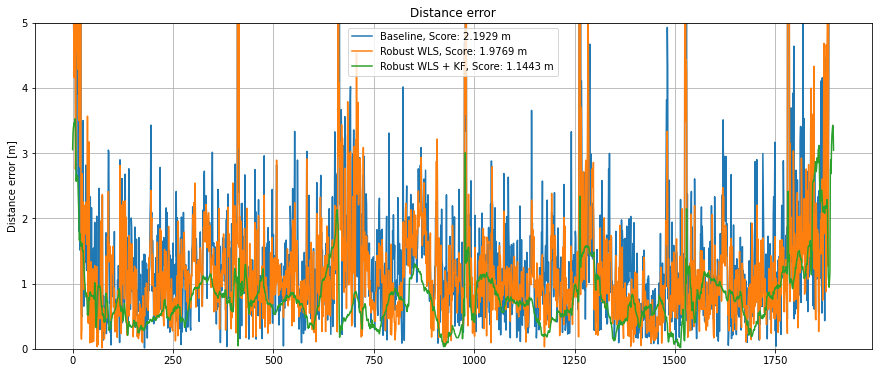

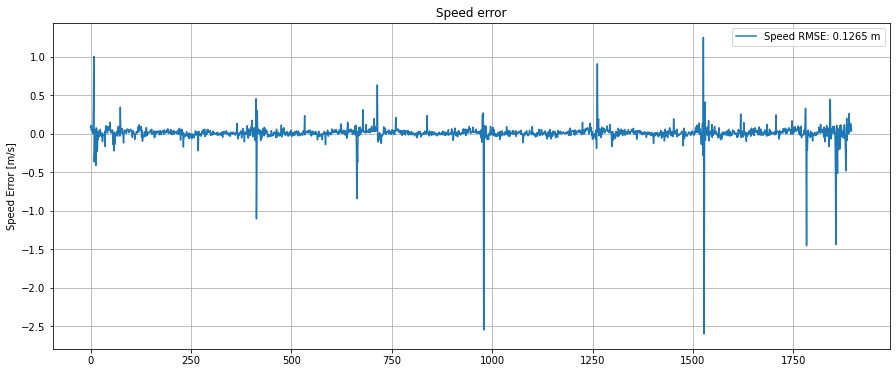

In [ ]:
# Plot distance error
plt.figure(figsize=(15,6))
plt.title('Distance error')
plt.ylabel('Distance error [m]')
plt.plot(vd_bl, label=f'Baseline, Score: {score_bl:.4f} m')
plt.plot(vd_wls, label=f'Robust WLS, Score: {score_wls:.4f} m')
plt.plot(vd_kf, label=f'Robust WLS + KF, Score: {score_kf:.4f} m')
plt.legend()
plt.grid()
plt.ylim([0, 5])

# Compute velocity error
speed_wls = np.linalg.norm(v_wls[:, :3], axis=1)
speed_gt = gt_df['SpeedMps'].to_numpy()
speed_rmse = np.sqrt(np.sum((speed_wls-speed_gt)**2)/len(speed_gt))

# Plot velocity error
plt.figure(figsize=(15,6))
plt.title('Speed error')
plt.ylabel('Speed Error [m/s]')
plt.plot(speed_wls - speed_gt, label=f'Speed RMSE: {speed_rmse:.4f} m')
plt.legend()
plt.grid()

### Mapping

In [ ]:
def convert_wgs_to_utm(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

llh_bl_df = pd.DataFrame(llh_bl, columns = ['lat', 'lon', 'Noise'])
llh_wls_df = pd.DataFrame(llh_wls, columns = ['lat', 'lon', 'Noise'])
llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])

gt_df.rename(columns = {'LatitudeDegrees':'lat', 'LongitudeDegrees':'lon'}, inplace = True)

all_tracks = pd.concat([gt_df, llh_bl_df, llh_wls_df, llh_kf_df])
all_tracks  =all_tracks[['lat', 'lon']]
all_tracks['Name'] = np.repeat(['gt','bl', 'wls','kf'],gt_df.shape[0])


In [ ]:
fig = px.line_mapbox(all_tracks, lat="lat", lon="lon",
                        color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig = px.line_mapbox(all_tracks, lat="lat", lon="lon",
                        color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [ ]:
## Trial 2: KNN-timeseries
from sklearn.neighbors import KNeighborsRegressor
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.utils import to_time_series_dataset
import random

## Trial Two (a):

# ## create datasets
# x = llh_kf_df.sample(3)
# time_series = to_time_series_dataset(llh_kf_df[['lat', 'lon']])

# ## model
# knn = KNeighborsTimeSeries(n_neighbors=1).fit(time_series)
# dataset = to_time_series_dataset(x) 
# knn.kneighbors(dataset, return_distance=False)


## Trial Two (b):

# # create datasets
# X = llh_kf_df
# y = gt_df[['lat', 'lon']]

# # model
# model = KNeighborsRegressor()
# # fit model
# knn_model = model.fit(X, y)
# # make a prediction
# yhat = model.predict(X)




# # Distance from ground truth
# vd_knn = vincenty_distance(yhat, llh_gt)



# # Score
# score_knn = calc_score(yhat[:-1, :], llh_gt[:-1, :])

# print(f'Score Baseline   {score_bl:.4f} [m]')
# print(f'Score Robust WLS {score_wls:.4f} [m]')
# print(f'Score KF         {score_kf:.4f} [m]')
# # print(f'Score NN         {score_nn:.4f} [m]')
# print(f'Score KNN         {score_knn:.4f} [m]')


## Trial Two (c):

# from sklearn.neighbors import NearestNeighbors

# X =  llh_kf_df
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
# nbrs.kneighbors(X)





In [ ]:
# bpath = '/content/drive/MyDrive/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'
# llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])
# llh_kf_df.to_csv(f'{path}/llh_kf_df.csv', index=False)\

In [ ]:
path = '/content/drive/MyDrive/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'
llh_kf_df = pd.read_csv(f'{path}/llh_kf_df.csv')
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth
llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

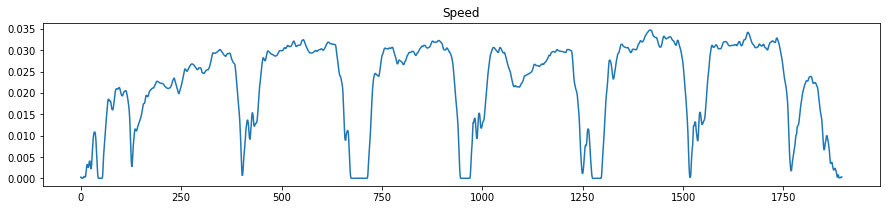

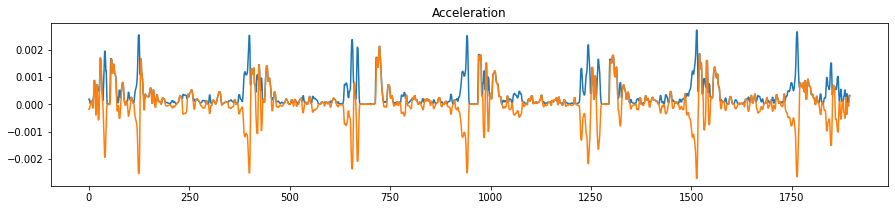

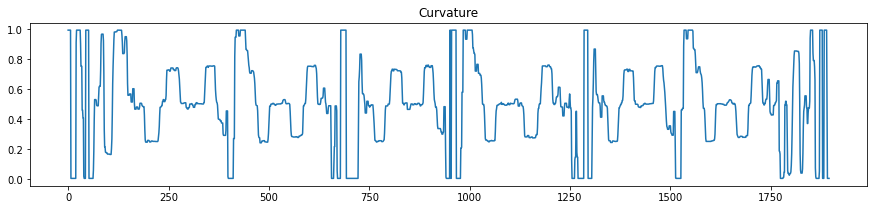

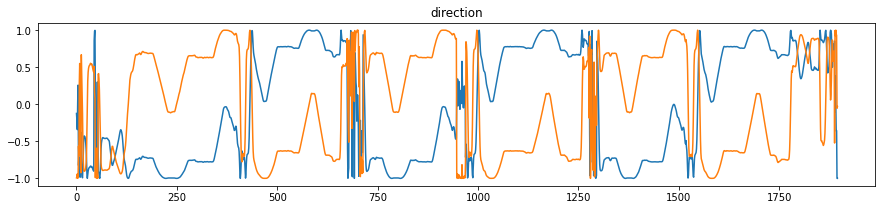

In [ ]:
llh_kf_df = add_features(llh_kf_df)

plt.figure(1, figsize=(15,3))
plt.title("Speed")
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['speed'])

plt.figure(2, figsize=(15,3))
plt.title("Acceleration")
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['acc'])
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['gas'])

plt.figure(3, figsize=(15,3))
plt.title("Curvature")
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['curve'])

plt.figure(4, figsize=(15,3))
plt.title("direction")
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['dir_x'])
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['dir_y'])

# plt.figure(11, figsize=(15,3))
# plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['dir_x_t'])
# plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['dir_y_t'])

In [ ]:
fig = px.scatter_mapbox(llh_kf_df,lat="lat", lon="lon", color="curve",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [ ]:
## Trial 3: SVR

# multioutput regression with an SVM model
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR

# define base model
model = LinearSVR()

# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)

# predict
yhat = wrapper.fit(X,y).predict(X)

# Distance from ground truth
vd_svr = vincenty_distance(yhat, llh_gt)



# Score
score_svr = calc_score(yhat[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')
print(f'Score svr         {score_svr:.4f} [m]')


Score Baseline   2.1929 [m]
Score Robust WLS 1.9769 [m]
Score KF         1.1443 [m]
Score svr         1378.3173 [m]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [ ]:
def convert_wgs_to_utm(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code


llh_svr_df = pd.DataFrame(yhat, columns = ['lat', 'lon'])

gt_df.rename(columns = {'LatitudeDegrees':'lat', 'LongitudeDegrees':'lon'}, inplace = True)

all_tracks = pd.concat([gt_df, llh_bl_df, llh_wls_df, llh_kf_df, llh_svr_df ])
all_tracks  =all_tracks[['lat', 'lon']]
all_tracks['Name'] = np.repeat(['gt','bl', 'wls','kf', 'svr'],gt_df.shape[0])

In [ ]:
fig = px.line_mapbox(all_tracks, lat="lat", lon="lon",
                        color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig = px.line_mapbox(all_tracks, lat="lat", lon="lon",
                        color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27},
                        height=600, width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [ ]:
## Trial 4: SVR-timeseries - took too long (stopped operation)
! pip install tslearn
from tslearn.svm import TimeSeriesSVC


# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)

# define dataset
X = llh_kf_df
y = gt_df[['lat', 'lon']]
# define base model
model = TimeSeriesSVC(kernel="gak", gamma="auto", probability=True)

# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)

# predict
yhat = wrapper.fit(X,y).predict(X)

# Distance from ground truth
vd_svrt = vincenty_distance(yhat, llh_gt)



# Score
score_svr = calc_score(yhat[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')
print(f'Score svrt       {score_svrt:.4f} [m]')




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self

KeyboardInterrupt: ignored

In [ ]:
! pip install --no-binary :all: lightgbm

from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
import lightgbm as lgb

def create_forecaster():
    
    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
    
    return forecaster

def grid_serch_forecaster(train, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
#     fh=np.arange(len(test))+1
#     y_pred = gscv.predict(fh=fh)
#     mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape
    
param_grid = {"window_length": [5, 10, 15, 20, 25, 30]} # parameter set to be grid searched
forecaster = create_forecaster()

In [ ]:
# Trial 6: seglean

! pip install seglearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from seglearn.pipe import Pype
from seglearn.split import temporal_split
from seglearn.transform import FeatureRep, SegmentXYForecast, last


# define dataset
X = llh_kf_df
y = gt_df[['lat', 'lon']]


# create a feature representation pipeline

clf = Pype([('segment', SegmentXYForecast(width=200, overlap=0.5, y_func=last, forecast=200)),
            ('features', FeatureRep()),('lin', LinearRegression())])

# fit 
clf.fit(X, y).predict(X)

### Preparation for ML

In [ ]:
sc = MinMaxScaler(feature_range=(-1,1))
x_data = np.array(llh_kf_df)
y_data = llh_gt
new_x_data = sc.fit_transform(x_data[:,2:])
new_x_data = new_x_data.reshape(new_x_data.shape[0],new_x_data.shape[1],1)
new_y_data = (y_data-x_data[:,0:2])*1e5

print('X_data shape :', x_data.shape)
print('new X_data shape :', new_x_data.shape)
print('y_data shape :', y_data.shape)
print('new y_data shape :', new_y_data.shape)

X_data shape : (1896, 9)
new X_data shape : (1896, 7, 1)
y_data shape : (1896, 2)
new y_data shape : (1896, 2)


In [ ]:
from tensorflow.python.keras.layers import Dense, LSTM, Conv1D

input_shape = (100, 6)

model = Sequential()

model.add(LSTM(units=20, batch_input_shape=(None,new_x_data.shape[1],1),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=10,return_sequences=False))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(units=2))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.summary()
          

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 7, 20)             1760      
_________________________________________________________________
lstm_23 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_44 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_45 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_46 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_48 (Dense)             (None, 2)               

### Model

In [ ]:
history = model.fit(new_x_data,new_y_data,epochs=50, verbose=2)

Train on 1896 samples
Epoch 1/50
1896/1896 - 1s - loss: 0.3469 - acc: 0.6530
Epoch 2/50
1896/1896 - 1s - loss: 0.2937 - acc: 0.6551
Epoch 3/50
1896/1896 - 1s - loss: 0.2778 - acc: 0.6566
Epoch 4/50
1896/1896 - 1s - loss: 0.2597 - acc: 0.6651
Epoch 5/50
1896/1896 - 1s - loss: 0.2528 - acc: 0.6862
Epoch 6/50
1896/1896 - 1s - loss: 0.2467 - acc: 0.6814
Epoch 7/50
1896/1896 - 1s - loss: 0.2403 - acc: 0.6872
Epoch 8/50
1896/1896 - 1s - loss: 0.2393 - acc: 0.6841
Epoch 9/50
1896/1896 - 1s - loss: 0.2371 - acc: 0.6835
Epoch 10/50
1896/1896 - 1s - loss: 0.2374 - acc: 0.6878
Epoch 11/50
1896/1896 - 1s - loss: 0.2347 - acc: 0.6878
Epoch 12/50
1896/1896 - 1s - loss: 0.2286 - acc: 0.6941
Epoch 13/50
1896/1896 - 1s - loss: 0.2324 - acc: 0.6878
Epoch 14/50
1896/1896 - 1s - loss: 0.2307 - acc: 0.6862
Epoch 15/50
1896/1896 - 1s - loss: 0.2267 - acc: 0.6888
Epoch 16/50
1896/1896 - 1s - loss: 0.2293 - acc: 0.6946
Epoch 17/50
1896/1896 - 1s - loss: 0.2261 - acc: 0.6925
Epoch 18/50
1896/1896 - 1s - loss: 

In [ ]:
model.save('/content/drive/MyDrive/model_0611.h5')
from tensorflow.python.keras.models import load_model
model1 = load_model('/content/drive/MyDrive/model_0611.h5')

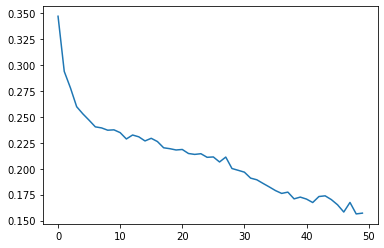

In [ ]:
plt.plot(history.history['loss'])
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2458: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



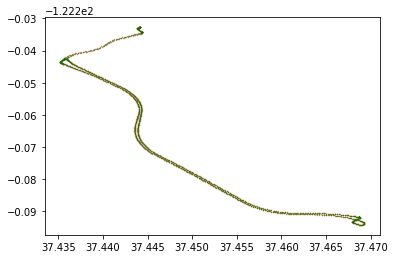

Score Baseline   2.1929 [m]
Score Robust WLS 1.9769 [m]
Score KF         1.1443 [m]
Score NN         0.6534 [m]


In [ ]:
res_df = (model.predict(new_x_data))/1e5 + x_data[:,0:2]

# Plotting actual points with GPS points

predicted_df = pd.DataFrame(data=res_df[0:,0:],index=[i for i in range(res_df.shape[0])],columns=['f'+str(i) for i in range(res_df.shape[1])])

actual_df = pd.DataFrame(data=llh_gt[0:,0:],index=[i for i in range(llh_gt.shape[0])],columns=['f'+str(i) for i in range(llh_gt.shape[1])])

# for i in range(len(res_df)):
# #   print(i)
plt.scatter(x=predicted_df['f0'],y=predicted_df['f1'],c='r',s=0.1,alpha=0.5)
plt.scatter(x=actual_df['f0'],y=actual_df['f1'],c='g',s=0.1,alpha=0.5)

plt.show()

# Distance from ground truth
vd_nn = vincenty_distance(res_df, llh_gt)

# Score
score_nn = calc_score(res_df[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')
print(f'Score NN         {score_nn:.4f} [m]')

In [ ]:
## Trial One:
# ! pip install tslearn
# from sklearn.datasets import make_regression
# from sklearn.neighbors import KNeighborsRegressor
# from tslearn.neighbors import KNeighborsTimeSeries
# from tslearn.utils import to_time_series_dataset
# import random

# ## Trial One (a):

# # create datasets

# number_of_rows = y_data.shape[0]
# random_indices = np.random.choice(number_of_rows, size=3, replace=False)
# random_rows = y_data[random_indices, :]


# X = x_data
# y = y_data

# # define model
# knn = KNeighborsTimeSeries(n_neighbors=1).fit(y) 
# dataset = to_time_series_dataset(random_rows) 
# dist, ind = knn.kneighbors(dataset, return_distance=True)

## Trial One (b):

# model = KNeighborsRegressor()
# # fit model
# knn_model = model.fit(X, y)
# # make a prediction
# yhat = (model.predict(X))/1e5 + x_data[:,0:2]



# # Distance from ground truth
# vd_knn = vincenty_distance(yhat, llh_gt)



# # Score
# score_knn = calc_score(yhat[:-1, :], llh_gt[:-1, :])

# print(f'Score Baseline   {score_bl:.4f} [m]')
# print(f'Score Robust WLS {score_wls:.4f} [m]')
# print(f'Score KF         {score_kf:.4f} [m]')
# print(f'Score NN         {score_nn:.4f} [m]')
# print(f'Score KNN         {score_knn:.4f} [m]')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self

In [ ]:
# Trial 5: KNN-NN 

# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# from numpy import zeros, newaxis
# # prepare data

# x_vals = new_x_data

# y_vals = new_y_data

# x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

# np.random.seed(59)
# train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace=False)
# test_indices =np.array(list(set(range(len(x_vals))) - set(train_indices)))

# x_vals_train = x_vals[train_indices]
# x_vals_test = x_vals[test_indices]
# y_vals_train = y_vals[train_indices]
# y_vals_test = y_vals[test_indices]

# feature_number = len(x_vals_train[0])

# k = 5



# x_data_train = tf.placeholder(shape=[None, feature_number], dtype=tf.float32)
# y_data_train = tf.placeholder(shape=[None, len(y_vals[0])], dtype=tf.float32)
# x_data_test = tf.placeholder(shape=[None, feature_number], dtype=tf.float32)

# # manhattan distance
# distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train, tf.expand_dims(x_data_test, 1))), axis=2)

# # nearest k points
# _, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
# top_k_label = tf.gather(y_data_train, top_k_indices)

# sum_up_predictions = tf.reduce_sum(top_k_label, axis=1)
# prediction = tf.argmax(sum_up_predictions, axis=1)


# sess = tf.Session()
# prediction_outcome = sess.run(prediction, feed_dict={x_data_train: x_vals_train,
#                                x_data_test: x_vals_test,
#                                y_data_train: y_vals_train})

# # evaluation
# accuracy = 0
# for pred, actual in zip(prediction_outcome, y_vals_test):
#     if pred == np.argmax(actual):
#         accuracy += 1

# print(accuracy / len(prediction_outcome))

### Validation

In [ ]:
path = '/content/drive/MyDrive/smartphone-decimeter-2022/'
cnt = 1
# Loop for each trip
for i, dirname in enumerate(tqdm(sorted(gl.glob(f'{path}/train/*/*/')))):
  # if cnt == 2:
  #   break
  drive, phone = dirname.split('/')[-3:-1]
  tripID = f'{drive}/{phone}'
  print(tripID)

  # Read data
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
  gt_df = pd.read_csv(f'{dirname}/ground_truth.csv')  # ground truth

  # Point positioning
  utc, x_wls, v_wls = point_positioning(gnss_df)

  # Exclude velocity outliers
  x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

  # Kalman smoothing
  x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

  # Convert to latitude and longitude
  llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

  # Save df
  llh_kf_df = pd.DataFrame(llh_kf, columns = ['lat', 'lon', 'Noise'])
  llh_kf_df.to_csv(f'{dirname}/llh_kf_df.csv', index=False)

  # Add features
  llh_kf_df = add_features(llh_kf_df)

  x_data = np.array(llh_kf_df)
  y_data = np.array(gt_df[['LatitudeDegrees', 'LongitudeDegrees']])
  test_x_data = sc.fit_transform(x_data[:,2:])
  test_x_data = test_x_data.reshape(test_x_data.shape[0],test_x_data.shape[1],1)
  res_df = (model.predict(test_x_data))/1e5 + x_data[:,0:2]

  # Ground truth
  llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

  # Distance from ground truth
  vd_kf = vincenty_distance(llh_kf, llh_gt)

  # Score
  score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])

  # Distance from ground truth
  vd_nn = vincenty_distance(res_df, llh_gt)

  # Score
  score_nn = calc_score(res_df[:-1, :], llh_gt[:-1, :])

  print(f'Score KF         {score_kf:.4f} [m]')
  print(f'Score NN         {score_nn:.4f} [m]')
  

  cnt = cnt+1

  0%|          | 0/170 [00:00<?, ?it/s]

2020-05-15-US-MTV-1/GooglePixel4XL


  0%|          | 0/3362 [00:00<?, ?it/s]

PermissionError: ignored

In [ ]:
path = '/content/drive/MyDrive/smartphone-decimeter-2022/'
results = pd.DataFrame()
# Loop for each trip
for i, dirname in enumerate(tqdm(sorted(gl.glob(f'{path}/train/*/*/')))):
  drive, phone = dirname.split('/')[-3:-1]
  tripID = f'{drive}/{phone}'
  print(tripID)

  # Read data
  kf_test = pd.read_csv(f'{dirname}/llh_kf_df.csv') # cleaned data
  gt_test = pd.read_csv(f'{dirname}/ground_truth.csv')  # ground truth
  kf_array = np.array(kf_test)

  # Add features
  kf_test = add_features(kf_test)
  test_x_data = sc.fit_transform(np.array(kf_test)[:,2:])
  test_x_data = test_x_data.reshape(test_x_data.shape[0],test_x_data.shape[1],1)
  res_df = (model.predict(test_x_data))/1e5 + np.array(kf_test)[:,0:2]

  # Ground truth
  gt_array = gt_test[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

  # Distance from ground truth
  vd_kf = vincenty_distance(kf_array, gt_array)

  # Score
  score_kf = calc_score(kf_array[:-1, :], gt_array[:-1, :])

  # Distance from ground truth
  vd_nn = vincenty_distance(res_df, gt_array)

  # Score
  score_nn = calc_score(res_df[:-1, :], gt_array[:-1, :])

  results = pd.concat([results, pd.DataFrame({"KF" : [score_kf], "NN" : [score_nn], "phone" : [phone]})])

In [ ]:
results2

In [ ]:
results2 = results
results2.reset_index(drop=True)
results2['improvement'] = results2['KF'] - results2['NN']

plt.figure(figsize=(15,6))

graph = sns.scatterplot('KF', 'improvement', data=results2, hue='phone')
graph.axhline(0)

plt.show()

plt.figure(figsize=(15,6))

graph2 = sns.histplot(results2.improvement)